In [0]:

# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.dropdown("data_load_type", "Full", ["Full"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
data_load_type = dbutils.widgets.get("data_load_type") # Full/Incremental
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name, data_load_type)



dev bimodelapi True cc-bi-ml-devqa01 Full

dev bimodelapi True cc-bi-ml-devqa01 Full

dev bimodelapi True cc-bi-ml-devqa01 Full

Total Row:summary/gl....531
Wrote 324101 bytes.
Total Row:summary/opportunities....593
Wrote 364308 bytes.
Total Row:summary/projects....700
Wrote 424947 bytes.
Total Row:summary/headcount....1983
Wrote 1202723 bytes.
Total Row:summary/project allocations....419
Wrote 220705 bytes.
Total Row:summary/pipeline....84513
Wrote 71681369 bytes.
Total Row:summary/pipeline trend....1272
Wrote 187011 bytes.

Converting to pandas...

Contributing Studio Location[Contrib Region Code],Contributing Studio Location[Contrib Region Name],Contributing Studio Location[Contrib Sub Region Code],Contributing Studio Location[Contrib Sub Region Name],Date[End of Month],Date[Month Year],Date[Relative Month Offset],Date[Year Month No],Date[Year],Pipeline Type[Pipeline Type],Report Currency[Report Currency Code],Snapshot Date[Relative Snapshot Month Offset],Snapshot Date[Snapshot Date],Snapshot Date[Snapshot End of Month],[Index],[Pipeline Value],[Pipeline at 100 Percent],[Yield Amount],[Yield]
Global,Global,Play Lab,Play Lab,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1000,"1,864.29","18,642.86",,
Global,Global,Play Lab,Play Lab,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Opportunity ML,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1001,"93,722.51","312,408.37","-5,607.62",-1.76%
NA,Unknown,NA,Unknown,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1002,"30,329.67","303,296.70",,
North America,North America,North America,North America,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Active Unrecognized,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1003,"151,766.19","151,766.19","-22,574.14",-21.95%
North America,North America,North America,North America,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1004,"1,094,028.39","4,748,673.31",,
North America,North America,North America,North America,2020-07-31T00:00:00,Jul 2020,-9,202007,2020,Opportunity ML,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1005,"2,236,849.54","3,478,368.65","682,853.73",25.67%
Academy,Academy,Academy,Academy,2020-08-31T00:00:00,Aug 2020,-8,202008,2020,Active Unrecognized,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1006,"15,702.48","15,702.48",,
Academy,Academy,Academy,Academy,2020-08-31T00:00:00,Aug 2020,-8,202008,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1007,687.50,"6,875.00",,
Asia,Asia,China,China,2020-08-31T00:00:00,Aug 2020,-8,202008,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1008,"362,436.65","402,707.39",,
Asia,Asia,Japan,Japan,2020-08-31T00:00:00,Aug 2020,-8,202008,2020,Opportunity,USD,-15,2020-01-12T00:00:00,2020-01-31T00:00:00,1009,"63,055.04","282,065.83",,


/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Revenue] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Current Opp Period Value, Opportunity Value] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Project Period Price, Project Price, Conversions] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Headcount, Headcount Contingent] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Nominal_Hours] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Pipeline, Pipeline at 100 Percent] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))
/databricks/spark/python/pyspark/sql/pandas/utils.py:81: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [Pipeline Trend] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
 "conversion.".format(", ".join(decimal_col_names))

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

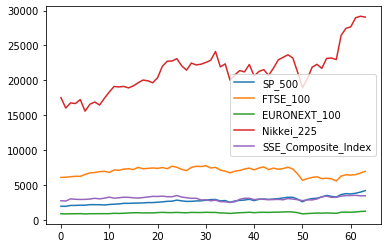

pipehist : (84513, 9)
talenthist : (1983, 5)
revhist : (531, 3)
opphist : (593, 7)
projhist : (700, 7)
pipetrend : (418, 4)
projectactualshist : (419, 4)

In [0]:
%run ./data_load_rev_region_forecast

In [0]:
# Prepare Data & Set time column and series columns
print("Preparing data")
# set variales

target_column_name = "Revenue"
time_column_name = "End_of_Month"
time_series_id_column_names = ["Relative_Offset", "Snp_Seq_No", "Sub_Region_Code"]
sort_cols_snp = ["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]
sort_cols_eom = ["End_of_Month", "Sub_Region_Code"]
final_sort_order = [time_column_name] + time_series_id_column_names
final_sort_order_ascending = [True, False, True, True]

exclude_sub_region = ["Singapore", "NA"]

pd.set_option("display.float_format", lambda x: "%.2f" % x)

talenthist1 = talenthist.copy()  # .toPandas() to convert from spark df to pandas
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
projectactualshist1 = projectactualshist.copy()

# pipetrend1.drop(columns="Snapshot_Date_Short", axis=1, inplace=True)

#pipehist1.rename(columns={"Snapshot_Date_Short": "Snapshot_Date"}, inplace=True)
#pipetrend1.rename(columns={"Snapshot_Date_Short": "Snapshot_Date"}, inplace=True)
#pipetrend1.rename(columns={"Snapshot_End_of_Month": "End_of_Month"}, inplace=True)
#talenthist1["Billable_Headcount"] = (
#    talenthist1["Headcount"] + talenthist1["Headcount_Contingent"]
#)
#talenthist1.drop(columns=["Headcount"], axis=1, inplace=True)

numeric_cols = [
    "Revenue",
    "Pipeline",
    "Pipeline_at_100_Percent",
    "Yield",
    "Pipeline_Trend",
    "Conversions",
    "Project_Period_Count",
    "Project_Count",
    "Project_Period_Price",
    "Project_Price",	
    "Opportunity_Period_Count",
    "Opportunity_Count",
    "Current_Opp_Period_Value",
    'Opportunity_Value',
    "Win_Rate",
    "Headcount",
    "Utilization_Billable",
    "Nominal_Hours"
]

df_list = [
    pipehist1,
    talenthist1,
    revhist1,
    opphist1,
    projhist1,
    pipetrend1,
    projectactualshist1
]
for x in df_list:
    x.infer_objects()

    # convert date to to_datetime

    x = convert_date_cols(x)
    
    # coerce numeric_cols to numeric
    x = coerce_to_numeric(x, numeric_cols)

    # replace null values to NA

    x["Sub_Region_Code"] = x["Sub_Region_Code"].replace(np.nan, "NA", regex=True)

    x = x.replace(np.nan, 0, regex=True)

    # make all dates to End of Month values to later merge
    if "End_of_Month" in x.columns:

        x["End_of_Month"] = x["End_of_Month"] + pd.offsets.MonthEnd(0)

    if "Snapshot_Date" in x.columns:

        # x['Snapshot_Date'] = x['Snapshot_Date'] + pd.offsets.MonthEnd(0)

        x.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)
    else:
        x.sort_values(by=sort_cols_eom).reset_index(drop=True)
    
    print(get_df_name(x), ":", x.shape)
    '''
    display(x.info())
    display(x.tail())
    '''

Preparing data
x : (84513, 9)
x : (1983, 5)
x : (531, 3)
x : (593, 7)
x : (700, 7)
x : (418, 4)
x : (419, 4)

In [0]:

# Preparing eom_region_snp_final 
# Cross join to get cross-join of all unquie values of End_of_Month + Relative_Offset + Snp_Seq_No + Sub_Region_Code with forward filling the last snapshot date for that relative_month
print("Preparing eom_region_snp_final")
# Set Parameters---------------------------------------------------------------------------------------------------------------------

past_period = 0
n_test_periods = 4
nan_value = 0
dt1 = pd.to_datetime('2018-07-31') #ignore revenues before pipeline data was not there

d = pd.date_range(start_date, today + pd.offsets.MonthEnd(n_test_periods), freq="m")
eom = pd.DataFrame(d, columns=["End_of_Month"])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)

sub_region = pd.DataFrame(
    pipehist1["Sub_Region_Code"].unique(), columns=["Sub_Region_Code"]
)
snp_date = pd.DataFrame(pipehist1["Snapshot_Date"].unique(), columns=["Snapshot_Date"])
#print("Debug:", snp_date["Snapshot_Date"].unique())

eom1 = df_crossjoin(snp_date, eom)
eom1 = eom1.reset_index(drop=True)

eom2 = df_crossjoin(eom1, sub_region)
eom2 = eom2.reset_index(drop=True)
# eom1 = eom.merge(snp_date, how="cross")
# eom2 = eom1.merge(sub_region, how="cross")

eom_region_snp = eom2.replace(np.nan, "NA", regex=True).query(
    "Sub_Region_Code not in @exclude_sub_region"
)
eom_region_snp = eom_region_snp.reset_index(drop=True)
# eom_region_snp.drop(columns=['key'], axis=1, inplace = True)
#print(pd.DataFrame(eom_region_snp.describe(include='all')))
# Add offset columns

eom_region_snp["Relative_Month_Offset"] = round(
    (eom_region_snp["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)
eom_region_snp["Relative_Snapshot_Month_Offset"] = round(
    (eom_region_snp["Snapshot_Date"] + pd.offsets.MonthEnd(0) - current_eom)
    / np.timedelta64(1, "M"),
    0,
).astype(int)
eom_region_snp["Relative_Offset"] = (
    eom_region_snp["Relative_Month_Offset"] -
    eom_region_snp["Relative_Snapshot_Month_Offset"]
)
eom_region_snp["Relative_Offset"] = eom_region_snp["Relative_Offset"].astype(int)
eom_region_snp["Snapshot_Day_of_Month"] = eom_region_snp["Snapshot_Date"].dt.day

eom_region_snp1 = eom_region_snp.copy()

# display(eom_region_snp.tail())

# Add a sequence number to each element in a group using python

eom_region_snp1 = eom_region_snp1.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)
#print("eom_region_snp1:")
#eom_region_snp1.info()
#display(eom_region_snp1.tail())


eom_region_snp2 = (
    eom_region_snp1[["End_of_Month", "Relative_Offset", "Snapshot_Date"]]
    .groupby(["End_of_Month", "Relative_Offset", "Snapshot_Date"])
    .last()
)

# eom_region_snp['Snp_Seq_No'] = normalize(eom_region_snp['Snapshot_Date'].dt.day,1,15) #Normalizing from one range to another

eom_region_snp2["Snp_Seq_No"] = eom_region_snp2.groupby(
    ["End_of_Month", "Relative_Offset"]
).cumcount()
#print(eom_region_snp2["Snp_Seq_No"].unique())

seq = pd.DataFrame()

seq["Snp_Seq_No"] = eom_region_snp2["Snp_Seq_No"].unique()
max_seq = seq["Snp_Seq_No"].max()

cols1 = ["End_of_Month", "Relative_Offset"]
eom_offset_region = eom_region_snp1[cols1].drop_duplicates()
eom_offset_seq = df_crossjoin(eom_offset_region, seq)

#display(eom_offset_seq)
eom_region_snp2 = eom_region_snp2.reset_index(
    level=eom_region_snp2.index.names
).reset_index(drop=True)
#print("eom_region_snp2:")
#eom_region_snp2.info()
#display(eom_region_snp2)
#display(seq.info())
#print("eom_region_snp2:", eom_region_snp2["Snp_Seq_No"].max())
#print("eom_region_snp2:", eom_region_snp2["Snapshot_Date"].max())
eom_region_snp3 = pd.merge(
    eom_offset_seq,
    eom_region_snp2,
    how = "left",
    on=["End_of_Month","Relative_Offset","Snp_Seq_No"]
)
eom_region_snp3 = eom_region_snp3.reset_index(drop=True)
#print("eom_region_snp3:")
#display(eom_region_snp3.info())

#display(eom_region_snp3.tail())
eom_region_snp3 = eom_region_snp3.ffill(axis=0)

#print("eom_region_snp3:", eom_region_snp3["Snapshot_Date"].max())

eom_region_snp_final = pd.merge(
    eom_region_snp1,
    eom_region_snp3,
    how="right",
    on=["End_of_Month", "Relative_Offset", "Snapshot_Date"],
).fillna(nan_value)
eom_region_snp_final = eom_region_snp_final.reset_index(drop=True)

eom_region_snp_final = eom_region_snp_final.replace(np.nan, 0, regex=True)
#print("eom_region_snp_final:")
#display(eom_region_snp_final.info())

int_cols = [
    "Relative_Snapshot_Month_Offset",
    "Relative_Month_Offset",
    "Relative_Offset",
    "Snp_Seq_No",
    "Snapshot_Day_of_Month"
]

eom_region_snp_final = coerce_to_int(eom_region_snp_final, int_cols)


#print(eom_region_snp_final["Snapshot_Date"].max())
# FILTER for relevant history and forecast period rows
main_filter = "Relative_Offset >= -@past_period and \
                Relative_Offset < @n_test_periods and \
                Relative_Snapshot_Month_Offset <= 0 and \
                Snp_Seq_No in [0, 1, 2, 3, @max_seq]"
    
eom_region_snp_final = eom_region_snp_final.query(main_filter).sort_values(by=final_sort_order).reset_index(drop=True)

eom_region_snp_final.to_csv(output_data_path + "eom_region_snp.csv", index=False)

print("eom_region_snp_final:")
#eom_region_snp_final['End_of_Month'].unique()
eom_region_snp_final.info()
#eom_region_snp_final.tail()


Preparing eom_region_snp_final
eom_region_snp_final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 8 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 20400 non-null datetime64[ns]
 1 End_of_Month 20400 non-null datetime64[ns]
 2 Sub_Region_Code 20400 non-null object 
 3 Relative_Month_Offset 20400 non-null int64 
 4 Relative_Snapshot_Month_Offset 20400 non-null int64 
 5 Relative_Offset 20400 non-null int64 
 6 Snapshot_Day_of_Month 20400 non-null int64 
 7 Snp_Seq_No 20400 non-null int64 
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 1.2+ MB

In [0]:
print(pd.DataFrame(eom_region_snp_final.describe(include='all').T))
'''
eom_region_snp_pvt = eom_region_snp_final.pivot_table(
    index=[time_column_name, "Relative_Offset"],
    columns=["Snp_Seq_No", "Sub_Region_Code"],
    values=["Snapshot_Date"],
    aggfunc={"Snapshot_Date": "count"},
    margins=False,
)
# eom_region_snp_pvt = eom_region_snp_pvt.reset_index(level=eom_region_snp_pvt.index.names).reset_index(drop=True)
#eom_region_snp_pvt
'''

count unique top freq first last mean std min 25% 50% 75% max
Snapshot_Date 20400 166 2021-02-28 00:00:00 240 2018-07-20 2021-04-28 NaN NaN NaN NaN NaN NaN NaN
End_of_Month 20400 48 2019-01-31 00:00:00 600 2017-08-31 2021-07-31 NaN NaN NaN NaN NaN NaN NaN
Sub_Region_Code 20400 8 Centers of Excellence 2550 NaT NaT NaN NaN NaN NaN NaN NaN NaN
Relative_Month_Offset 20400.00 NaN NaN NaN NaT NaT -20.50 10.72 -44.00 -29.00 -20.50 -12.00 3.00
Relative_Snapshot_Month_Offset 20400.00 NaN NaN NaN NaT NaT -16.50 9.81 -33.00 -25.00 -16.50 -8.00 0.00
Relative_Offset 20400.00 NaN NaN NaN NaT NaT -4.00 4.32 -11.00 -8.00 -4.00 0.00 3.00
Snapshot_Day_of_Month 20400.00 NaN NaN NaN NaT NaT 18.32 9.52 1.00 10.00 19.00 28.00 31.00
Snp_Seq_No 20400.00 NaN NaN NaN NaT NaT 3.00 3.16 0.00 1.00 2.00 3.00 9.00
Out[55]: '\neom_region_snp_pvt = eom_region_snp_final.pivot_table(\n index=[time_column_name, "Relative_Offset"],\n columns=["Snp_Seq_No", "Sub_Region_Code"],\n values=["Snapshot_Date"],\n aggfunc={"Snapshot_Date": "count"},\n margins=False,\n)\n# eom_region_snp_pvt = eom_region_snp_pvt.reset_index(level=eom_region_snp_pvt.index.names).reset_index(drop=True)\n#eom_region_snp_pvt\n'

In [0]:

# Pivot Talent from long to wide to match month end grain
print("Preparing talent wide")
nan_value = 0
#display(talenthist1.tail())

talenthist_wide1 = talenthist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    columns=["Billable"], #, "Journey_Level"
    values=["Headcount"],
    aggfunc={"Headcount": np.sum},
    margins=False,
).fillna(nan_value)


talenthist_wide1.columns = [
    "_".join(tuple(map(str, t))) for t in talenthist_wide1.columns.values
]

'''
"Headcount_Billable_Temp",
             "Headcount_Billable_Unknown",
             "Headcount_Non-Billable_Unknown",
             "Headcount_Unknown_Director",
             "Headcount_Unknown_Enterprise",
             "Headcount_Unknown_Individual",
             "Headcount_Unknown_Team",
             "Headcount_Unknown_Unknown"
''' 
talenthist_wide1.reset_index(inplace=True)
talent_cols1 = talenthist_wide1.columns
remove_list1 = ["End_of_Month", "Sub_Region_Code", "Headcount", "Headcount_Unknown"]
talent_cols1 = difflist(talent_cols1, remove_list1)
talenthist_wide1.drop(
    columns=["Headcount_Unknown"], axis=1, inplace = True)
#print(talent_cols1)

#display(talenthist_wide1.tail())

# Sum contingent at month, billable, sub-region level
talenthist_wide2 = talenthist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    columns=["Billable"],
    values=["Headcount_Contingent"],
    aggfunc={"Headcount_Contingent": np.sum},
    margins=False,
).fillna(nan_value)

talenthist_wide2.columns = [
    "_".join(tuple(map(str, t))) for t in talenthist_wide2.columns.values
]

talenthist_wide2.reset_index(inplace=True)
talent_cols2 = talenthist_wide2.columns
remove_list2 = ["End_of_Month", "Sub_Region_Code", "Headcount_Contingent"]
talent_cols2 = difflist(talent_cols2, remove_list2)
#talenthist_wide2.drop(columns=[""], axis=1, inplace = True)
#print(talent_cols2)

# talenthist_wide.tail()
# pipetrend_wide['Pipeline'] = pd.to_numeric(pipetrend_wide['Pipeline'], errors='coerce').astype(int)

talent_cols = talent_cols1 + talent_cols2
numeric_cols_talent = numeric_cols
numeric_cols_talent = numeric_cols_talent + talent_cols
numeric_cols = numeric_cols_talent
#print(numeric_cols)

talenthist_wide1 = coerce_to_numeric(talenthist_wide1, numeric_cols)
talenthist_wide1 = convert_date_cols(talenthist_wide1)
talenthist_wide1 = talenthist_wide1.sort_values(by=sort_cols_eom).reset_index(drop=True)

talenthist_wide2 = coerce_to_numeric(talenthist_wide2, numeric_cols)
talenthist_wide2 = convert_date_cols(talenthist_wide2)
talenthist_wide2 = talenthist_wide2.sort_values(by=sort_cols_eom).reset_index(drop=True)
#print(talenthist_wide1.info())
# print(' pipetrend_wide: ')

#display(talenthist_wide1.info())
#display(talenthist_wide2.info())
'''
# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
#print("talenthist_wide:", talenthist_wide.shape)
#talenthist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')
'''

Preparing talent wide
Out[56]: '\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\n#print("talenthist_wide:", talenthist_wide.shape)\n#talenthist_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n'

In [0]:

# Pivot ProjectActuals from long to wide to match month end grain
print("Preparing ProjectActuals wide")
nan_value = 0

projectactualshist_wide = projectactualshist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    #columns="Journey_Level",
    values=["Utilization_Billable","Nominal_Hours"],
    aggfunc={"Utilization_Billable": np.mean, "Nominal_Hours": np.sum},
    margins=False,
).fillna(nan_value)


#projectactualshist_wide.columns = [
#    "_".join(tuple(map(str, t))) for t in projectactualshist_wide.columns.values
#]

projectactualshist_wide.reset_index(inplace=True)
'''
,"Utilization_Billable_Temp",
               "Utilization_Billable_Unknown",
               "Nominal_Hours_Temp"
'''
projectactuals_cols = projectactualshist_wide.columns
remove_list = ["End_of_Month", "Sub_Region_Code", "Utilization_Billable"
              ]
projectactuals_cols = difflist(projectactuals_cols, remove_list)
#projectactualshist_wide.drop(
#    columns=[""], axis=1, inplace = True)
#print(projectactuals_cols)
    
numeric_cols_projectactuals = numeric_cols
numeric_cols_projectactuals = numeric_cols_projectactuals + projectactuals_cols
#print(numeric_cols_projectactuals)

numeric_cols = numeric_cols_projectactuals
projectactualshist_wide = coerce_to_numeric(projectactualshist_wide, numeric_cols)
projectactualshist_wide = convert_date_cols(projectactualshist_wide)
projectactualshist_wide = projectactualshist_wide.sort_values(by=sort_cols_eom).reset_index(drop=True)

# print(' projectactualshist_wide: ')

#display(projectactualshist_wide.info())
#display(projectactualshist_wide.tail())
'''
# projectactualshist_wide.query('Fin_Entity_ID==@entity_debug')
print("projectactualshist_wide:", projectactualshist_wide.shape)
'''


Preparing ProjectActuals wide
Out[57]: '\n# projectactualshist_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("projectactualshist_wide:", projectactualshist_wide.shape)\n'

In [0]:

# Pivot Pipeline_Trend from long to wide to match month end grain
'''
print("Preparing Pipeline_Trend Wide")

nan_value = 0
pipetrend_wide = pipetrend1.pivot_table(
    index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],
    columns="Pipeline_Type",
    values=["Pipeline_Trend"],  # , 'Pipeline_3M_Rolling_Avg'
    aggfunc={"Pipeline_Trend": np.sum},
    margins=False,
).fillna(nan_value)


pipetrend_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values
]

pipe_cols = [
    "Active_Unrecognized_Trend",
    "Opportunity_Trend",
    "Opportunity_ML_Trend",  # ,    "Recognized",
]

pipetrend_wide.columns = pipe_cols

pipetrend_wide = pipetrend_wide.reset_index(
    level=pipetrend_wide.index.names
).reset_index(drop=True)

numeric_cols_pipetrend = numeric_cols
numeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols
if "Pipeline_Trend" in numeric_cols_pipetrend:
    numeric_cols_pipetrend.remove("Pipeline_Trend")
print(numeric_cols_pipetrend)

numeric_cols = numeric_cols_pipetrend
pipetrend_wide = convert_date_cols(pipetrend_wide)
pipetrend_wide = coerce_to_numeric(pipetrend_wide,numeric_cols)
pipetrend_wide = coerce_to_int(pipetrend_wide, int_cols)

pipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)

# print(' pipetrend_wide: ')

display(pipetrend_wide.info())

# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
print("pipetrend_wide:", pipetrend_wide.shape)
#pipetrend_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')

'''

Out[58]: '\nprint("Preparing Pipeline_Trend Wide")\n\nnan_value = 0\npipetrend_wide = pipetrend1.pivot_table(\n index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],\n columns="Pipeline_Type",\n values=["Pipeline_Trend"], # , \'Pipeline_3M_Rolling_Avg\'\n aggfunc={"Pipeline_Trend": np.sum},\n margins=False,\n).fillna(nan_value)\n\n\npipetrend_wide.columns = [\n "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values\n]\n\npipe_cols = [\n "Active_Unrecognized_Trend",\n "Opportunity_Trend",\n "Opportunity_ML_Trend", # , "Recognized",\n]\n\npipetrend_wide.columns = pipe_cols\n\npipetrend_wide = pipetrend_wide.reset_index(\n level=pipetrend_wide.index.names\n).reset_index(drop=True)\n\nnumeric_cols_pipetrend = numeric_cols\nnumeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols\nif "Pipeline_Trend" in numeric_cols_pipetrend:\n numeric_cols_pipetrend.remove("Pipeline_Trend")\nprint(numeric_cols_pipetrend)\n\nnumeric_cols = numeric_cols_pipetrend\npipetrend_wide = convert_date_cols(pipetrend_wide)\npipetrend_wide = coerce_to_numeric(pipetrend_wide,numeric_cols)\npipetrend_wide = coerce_to_int(pipetrend_wide, int_cols)\n\npipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)\n\n# print(\' pipetrend_wide: \')\n\ndisplay(pipetrend_wide.info())\n\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("pipetrend_wide:", pipetrend_wide.shape)\n#pipetrend_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n\n'

In [0]:

# Merge eom_studio with Revenue, Talent, Opportunity, Project
print("Preparing merge_df")
from functools import reduce

nan_value = 0
merge_dfs = [eom_region_snp_final, revhist1, projhist1, opphist1, projectactualshist_wide, talenthist_wide1, talenthist_wide2]

merge_df = reduce(
    lambda left, right: pd.merge(
        left, right, how="left", on=["End_of_Month", "Sub_Region_Code"]
    ),
    merge_dfs,
).fillna(nan_value)


merge_df = convert_date_cols(merge_df)
merge_df = coerce_to_numeric(merge_df, numeric_cols)
merge_df = coerce_to_int(merge_df, int_cols)

merge_df = merge_df.replace(np.nan, 0, regex=True)
merge_df.sort_values(by=sort_cols_snp).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

#print(" merge_df: ", merge_df.shape)

# merge_df.to_csv(output_data_path   'merge_df.csv', index=False)
# show_stats(merge_df)

print("merge_df: ", merge_df["Snapshot_Date"].max())
merge_df.info()

#print(merge_df.shape)
#merge_df.tail()  # .query('Fin_Entity_ID==@entity_debug')')


Preparing merge_df
merge_df: 2021-04-28 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20400 entries, 0 to 20399
Data columns (total 26 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 20400 non-null datetime64[ns]
 1 End_of_Month 20400 non-null datetime64[ns]
 2 Sub_Region_Code 20400 non-null object 
 3 Relative_Month_Offset 20400 non-null int64 
 4 Relative_Snapshot_Month_Offset 20400 non-null int64 
 5 Relative_Offset 20400 non-null int64 
 6 Snapshot_Day_of_Month 20400 non-null int64 
 7 Snp_Seq_No 20400 non-null int64 
 8 Revenue 20400 non-null float64 
 9 Project_Period_Count 20400 non-null float64 
 10 Project_Count 20400 non-null float64 
 11 Project_Period_Price 20400 non-null float64 
 12 Project_Price 20400 non-null float64 
 13 Conversions 20400 non-null float64 
 14 Opportunity_Period_Count 20400 non-null float64 
 15 Opportunity_Count 20400 non-null float64 
 16 Current_Opp_Period_Value 20400 non-null float64 
 17 Opportunity_Value 20400 non-null float64 
 18 Win_Rate 20400 non-null float64 
 19 Nominal_Hours 20400 non-null float64 
 20 Utilization_Billable 20400 non-null float64 
 21 Headcount_Billable 20400 non-null float64 
 22 Headcount_Non-Billable 20400 non-null float64 
 23 Headcount_Contingent_Billable 20400 non-null float64 
 24 Headcount_Contingent_Non-Billable 20400 non-null float64 
 25 Headcount_Contingent_Unknown 20400 non-null float64 
dtypes: datetime64[ns](2), float64(18), int64(5), object(1)
memory usage: 4.2+ MB

In [0]:

# Merge with eom_region_snp1 with stock_final_pivot
print("Preparing merge_df1")
# eom1 = eom  # pd.DataFrame(d, columns=['End_of_Month'])
# stock_final_df = pd.merge(
#    eom_region_snp1, stock_final_pivot, how="left", on=["End_of_Month","Relative_Month_Offset","Relative_Snapshot_Month_Offset","Relative_Offset"]
# ).fillna(nan_value)

# sp500_df = sp500_df.ffill(axis = 0)

# stock_final_df = stock_final_df.sort_values(by=sort_cols_eom).reset_index(drop=True)
# display(sp500_df.tail(10))
merge_df1 = pd.merge(merge_df, stock_final_pivot, how="left", on="End_of_Month").fillna(
    nan_value
)
#print(symbols_name)

numeric_cols_stock = numeric_cols
numeric_cols_stock = numeric_cols_stock + symbols_name
#if "Pipeline_Trend" in numeric_cols_stock:
#    numeric_cols_stock.remove("Pipeline_Trend")
#print(numeric_cols_stock)

numeric_cols = numeric_cols_stock
merge_df1 = convert_date_cols(merge_df1)
merge_df1 = coerce_to_numeric(merge_df1, numeric_cols)
merge_df1 = coerce_to_int(merge_df1, int_cols)

merge_df1 = merge_df1.sort_values(by=final_sort_order).reset_index(drop=True)
# merge_df1.to_csv(output_data_path   'merge_df1.csv', index=False)
# merge_sdf1 = spark.createDataFrame(merge_df1);
# merge_sdf1.write.format("parquet").mode("overwrite").parquet(output_data_path   'merge_df1.parquet')

# show_stats(merge_df1.tail(10))
# merge_df1.info()
#print(merge_df1.shape)

print("merge_df1: ", merge_df1["Snapshot_Date"].max())
merge_df1.info()
#merge_df1.tail()



Preparing merge_df1
merge_df1: 2021-04-28 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 31 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 20400 non-null datetime64[ns]
 1 End_of_Month 20400 non-null datetime64[ns]
 2 Sub_Region_Code 20400 non-null object 
 3 Relative_Month_Offset 20400 non-null int64 
 4 Relative_Snapshot_Month_Offset 20400 non-null int64 
 5 Relative_Offset 20400 non-null int64 
 6 Snapshot_Day_of_Month 20400 non-null int64 
 7 Snp_Seq_No 20400 non-null int64 
 8 Revenue 20400 non-null float64 
 9 Project_Period_Count 20400 non-null float64 
 10 Project_Count 20400 non-null float64 
 11 Project_Period_Price 20400 non-null float64 
 12 Project_Price 20400 non-null float64 
 13 Conversions 20400 non-null float64 
 14 Opportunity_Period_Count 20400 non-null float64 
 15 Opportunity_Count 20400 non-null float64 
 16 Current_Opp_Period_Value 20400 non-null float64 
 17 Opportunity_Value 20400 non-null float64 
 18 Win_Rate 20400 non-null float64 
 19 Nominal_Hours 20400 non-null float64 
 20 Utilization_Billable 20400 non-null float64 
 21 Headcount_Billable 20400 non-null float64 
 22 Headcount_Non-Billable 20400 non-null float64 
 23 Headcount_Contingent_Billable 20400 non-null float64 
 24 Headcount_Contingent_Non-Billable 20400 non-null float64 
 25 Headcount_Contingent_Unknown 20400 non-null float64 
 26 EURONEXT_100 20400 non-null float64 
 27 FTSE_100 20400 non-null float64 
 28 Nikkei_225 20400 non-null float64 
 29 SP_500 20400 non-null float64 
 30 SSE_Composite_Index 20400 non-null float64 
dtypes: datetime64[ns](2), float64(23), int64(5), object(1)
memory usage: 4.8+ MB

In [0]:

# Pivot Pipeline_Type from long to wide to match month end grain
print("Preparing pipehist_wide")
pipehist_long = pipehist1.copy()
pipehist_wide = pipehist_long.pivot_table(
    index=[
        "Snapshot_Date",
        "End_of_Month",
        "Sub_Region_Code",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset"
    ],
    columns="Pipeline_Type",
    values=["Pipeline", "Pipeline_at_100_Percent", "Yield"],  
    # aggfunc={"Pipeline": np.sum},
    margins=False,
).fillna(nan_value)

pipehist_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipehist_wide.columns.values
]
pipehist_wide.columns = pipehist_wide.columns.astype(str).str.replace(' ', '_')
pipehist_wide.reset_index(inplace=True)

'''
"Yield_Opportunity", "Pipeline_at_100_Percent_Recognized",
               "Pipeline_at_100_Percent_Active_Unrecognized"
'''
pipe_cols = pipehist_wide.columns
remove_list = ["Pipeline", "Pipeline_at_100_Percent", "Yield", 
               "Yield_Opportunity"
               ]
pipe_cols = difflist(projectactuals_cols, remove_list)
#print(pipe_cols)
    
numeric_cols_pipe = numeric_cols
numeric_cols_pipe = numeric_cols_pipe + pipe_cols
pipehist_wide.drop(
    columns=["Yield_Opportunity"], axis=1, inplace = True)
#print(numeric_cols_pipe)

numeric_cols = numeric_cols_pipe
pipehist_wide = convert_date_cols(pipehist_wide)
pipehist_wide = coerce_to_numeric(pipehist_wide, numeric_cols)
pipehist_wide = coerce_to_int(pipehist_wide, int_cols)

pipehist_wide = pipehist_wide.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)

# print(' pipehist_wide: ')

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')

print("pipehist_wide: ", pipehist_wide["Snapshot_Date"].max())
print("Pipehist_wide:", pipehist_wide.shape)

pd.DataFrame(pipehist_wide.describe(include='all'))

#pipehist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')



Preparing pipehist_wide
pipehist_wide: 2021-04-28 00:00:00
Pipehist_wide: (67530, 16)
Out[61]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized
count,67530,67530,67530,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00,67530.00
unique,177,63,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,2021-04-27 00:00:00,2017-01-31 00:00:00,North America,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,504,1593,9693,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,2018-07-20 00:00:00,2017-01-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,2021-04-28 00:00:00,2022-03-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,-13.66,-26.62,99355.25,49407.08,70978.67,1326497.65,99355.25,165021.08,114414.04,1326497.65,-0.01,0.07,0.43
std,NaN,NaN,NaN,9.46,15.78,659619.69,296714.34,416492.41,2827329.64,659619.69,801026.44,714515.22,2827329.64,0.09,0.57,5.63
min,NaN,NaN,NaN,-33.00,-51.00,-119607.00,0.00,0.00,-761937.07,-119607.00,0.00,0.00,-761937.07,-4.57,-1.00,-3.10
25%,NaN,NaN,NaN,-21.00,-40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.21


In [0]:

# FINAL MERGE with Pipeline and Pipeline Trend
print("Preparing merge_final")

'''
# Old version
# Get last (1) rows of each group for Pipeline Trend
pipetrend2 = pipetrend2.sort_values(by=["End_of_Month", "Sub_Region_Code", "Snapshot_Date"]).reset_index(drop=True)
#print("eom_region_snp1:")
#eom_region_snp1.info()
#display(eom_region_snp1.tail())

pipetrend2 = (
    pipetrend2
    .groupby(["End_of_Month", "Sub_Region_Code"])
    .tail(1)
)
pipetrend2.drop("Snapshot_Date", axis = 1, inplace = True)
#display(pipetrend2)

merge_df2 = pd.merge(
    merge_df1,
    pipetrend2,
    how="left",
    on=["End_of_Month", "Sub_Region_Code"]
).fillna(nan_value)
'''
# Merge with Pipelinte Trend using merge_asof with the nearest snapshot_date

print("Sort Order:", final_sort_order)
#display(pipetrend1)
# set the sort order same before the fuzzy merge
pipetrend2 = pipetrend1.drop("End_of_Month", axis = 1) #, inplace = True
pipetrend2 = pipetrend2.sort_values(by=["Snapshot_Date", "Sub_Region_Code"])
merge_df1 = merge_df1.sort_values(by=["Snapshot_Date", "Sub_Region_Code"])
#print("merge_df1: ", merge_df1["Snapshot_Date"].max())
#print("pipetrend2: ", pipetrend2["Snapshot_Date"].max())
merge_df2 = pd.merge_asof(
    left=merge_df1,
    right=pipetrend2,
    on=["Snapshot_Date"],
    by=["Sub_Region_Code"],
    direction='nearest'
).fillna(nan_value)

merge_df2 = convert_date_cols(merge_df2)
merge_df2 = coerce_to_numeric(merge_df2, numeric_cols)
merge_df2 = coerce_to_int(merge_df2, int_cols)
#display(merge_df2.query('Relative_Month_Offset == -1 and Sub_Region_Code == "North America"'))

# Merge with Pipeline History
pipehist_wide1 = pipehist_wide.copy()
merge_df2 = merge_df2.sort_values(by=final_sort_order,ascending=final_sort_order_ascending)
pipehist_wide1 = pipehist_wide1.sort_values(by=sort_cols_snp)

merge_final = pd.merge(
    merge_df2,
    pipehist_wide1,
    how="left",
    on=[
        "Snapshot_Date",
        "End_of_Month",
        "Sub_Region_Code",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset"
    ],
).fillna(nan_value)
# print(merge_final.info())
# print(merge_final.tail())
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end
#display(merge_final.tail())
merge_final = merge_final.infer_objects()
merge_final = convert_date_cols(merge_final)
merge_final = coerce_to_numeric(merge_final, numeric_cols)
merge_final = coerce_to_int(merge_final, int_cols)

merge_final = merge_final.sort_values(by=final_sort_order, ascending=final_sort_order_ascending).reset_index(drop=True)


merge_final.to_csv(output_data_path + "merge_final.csv", index=False)
merge_final.to_parquet(output_data_path + "merge_final.parquet", index=None)
#pipehist1.to_csv(output_data_path + "pipehist1_ts.csv", index=False)

"""
#merge_final_sdf = spark.createDataFrame(merge_final);
#merge_final_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'merge_final.parquet')
"""
print("merge_final:", merge_final.shape)
# merge_final.tail()
#print(merge_final["Snapshot_Date"].unique())
# merge_final.query('Relative_Snapshot_Month_Offset == 0')
# show_stats(merge_final)
pd.DataFrame(merge_final.describe(include='all').T)


Preparing merge_final
Sort Order: ['End_of_Month', 'Relative_Offset', 'Snp_Seq_No', 'Sub_Region_Code']
merge_final: (20400, 43)
Out[62]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,20400,166,2021-02-28 00:00:00,240,2018-07-20,2021-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,20400,48,2019-01-31 00:00:00,600,2017-08-31,2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,20400,8,Centers of Excellence,2550,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,20400.00,NaN,NaN,NaN,NaT,NaT,-20.50,10.72,-44.00,-29.00,-20.50,-12.00,3.00
Relative_Snapshot_Month_Offset,20400.00,NaN,NaN,NaN,NaT,NaT,-16.50,9.81,-33.00,-25.00,-16.50,-8.00,0.00
Relative_Offset,20400.00,NaN,NaN,NaN,NaT,NaT,-4.00,4.32,-11.00,-8.00,-4.00,0.00,3.00
Snapshot_Day_of_Month,20400.00,NaN,NaN,NaN,NaT,NaT,18.32,9.52,1.00,10.00,19.00,28.00,31.00
Snp_Seq_No,20400.00,NaN,NaN,NaN,NaT,NaT,3.00,3.16,0.00,1.00,2.00,3.00,9.00
Revenue,20400.00,NaN,NaN,NaN,NaT,NaT,1819101.36,3128847.85,-520093.90,279199.12,709429.43,1246386.06,12137512.77
Project_Period_Count,20400.00,NaN,NaN,NaN,NaT,NaT,23.49,44.51,0.00,4.00,7.00,15.00,250.00


In [0]:
merge_final.query('Relative_Month_Offset == -1 and Sub_Region_Code == "North America" and Snp_Seq_No == @max_seq').tail()

Out[63]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp_Period_Value,Opportunity_Value,Win_Rate,Nominal_Hours,Utilization_Billable,Headcount_Billable,Headcount_Non-Billable,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized
19838,2020-12-31,2021-03-31,North America,-1,-4,3,31,9,9800519.79,145.00,385.00,49667755.83,119743803.83,6753998.00,82.00,181.00,25072380.00,66200254.00,0.06,65899.60,0.48,279.95,71.50,33.00,12.00,3.00,1195.05,6713.60,29178.80,3972.89,3441.91,20051848.68,2757588.33,1161462.34,4087505.53,0.00,2757588.33,4697503.53,6637265.52,0.00,-0.04,-0.09,0.00
19878,2021-01-31,2021-03-31,North America,-1,-3,2,31,9,9800519.79,145.00,385.00,49667755.83,119743803.83,6753998.00,82.00,181.00,25072380.00,66200254.00,0.06,65899.60,0.48,279.95,71.50,33.00,12.00,3.00,1195.05,6713.60,29178.80,3972.89,3441.91,20051848.68,5723329.04,1353901.15,4088757.95,0.00,5723329.04,4224060.25,6526704.72,0.00,0.00,0.10,0.00
19918,2021-02-28,2021-03-31,North America,-1,-2,1,28,9,9800519.79,145.00,385.00,49667755.83,119743803.83,6753998.00,82.00,181.00,25072380.00,66200254.00,0.06,65899.60,0.48,279.95,71.50,33.00,12.00,3.00,1195.05,6713.60,29178.80,3972.89,3441.91,20051848.68,8168890.44,442730.01,1437589.14,0.00,8168890.44,1142222.92,1843662.09,0.00,0.00,0.04,0.00
19958,2021-03-31,2021-03-31,North America,-1,-1,0,31,9,9800519.79,145.00,385.00,49667755.83,119743803.83,6753998.00,82.00,181.00,25072380.00,66200254.00,0.06,65899.60,0.48,279.95,71.50,33.00,12.00,3.00,1195.05,6713.60,29178.80,3972.89,3441.91,20051848.68,9810107.44,0.00,0.00,6990.17,9810107.44,0.00,0.00,6990.17,0.06,0.00,0.00
19998,2021-04-28,2021-03-31,North America,-1,0,-1,28,9,9800519.79,145.00,385.00,49667755.83,119743803.83,6753998.00,82.00,181.00,25072380.00,66200254.00,0.06,65899.60,0.48,279.95,71.50,33.00,12.00,3.00,1195.05,6713.60,29178.80,3972.89,3441.91,20051848.68,0.00,0.00,0.00,9800520.89,0.00,0.00,0.00,9800520.89,0.00,0.00,0.06


In [0]:
merge_final["Snapshot_Date"].max()

Out[64]: Timestamp('2021-04-28 00:00:00')